In [1]:
import numpy as np
import matplotlib.pyplot as plt

First of all: we are going to introduce a dataset on that we apply our clustering method on:

In [2]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    epsilon = 0.1
    n = (np.random.rand(n_points,1)+epsilon) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise

    # hstack/vstack stacks data on top of each other (print shape to see what I mean)
    C_1 = np.hstack((d1x,d1y))
    C_2 = np.hstack((-d1x,-d1y))
    return np.vstack((C_1, C_2))

This is a dataset consisting of clusters twisting around each other. You don't need to understand the mathematics behind it, but you can play around with it if you like (make sure to train on the original dataset, not one you created)

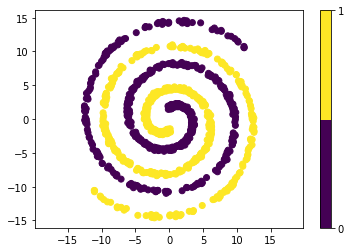

In [3]:
data_size = 500

dataset = twospirals(data_size)
labels = np.hstack((np.zeros(data_size),np.ones(data_size)))

# scatter makes a 2D scatter plot. Unfortunately you have to seperate the x-dim from the y-dim
# the labels are helpful for coloring. The algorithm does not use them, since this is unsupervised
plt.scatter(dataset[:,0], dataset[:,1], c = labels, cmap=plt.get_cmap('viridis',2))
plt.colorbar(ticks=np.arange(0,2))
plt.axis('equal')
plt.show()

In [4]:
import sys 
  
# the setrecursionlimit function is 
# used to modify the default recursion 
# limit set by python. Using this,  
# we can increase the recursion limit 
# to satisfy our needs 
  
sys.setrecursionlimit(10**6) 


def euclidean_distance(x_1, x_2):
      return np.sqrt(np.sum((x_1-x_2)**2))#, axis = 1))



# Exercise 1. Implementation of a DBSCAN-Classiﬁer

a) Implement the DBSCAN algorithm to classify points of the two clusters.

b) Plot a scatter plot highlighting the clusters that were found after finding good hyperparameter values eps and minPts.

c) Print accuracies for different data_size values.

d) For what kind of data_size values does the algorithm fail and why? What would you say are disadvantages of DBSCAN?

## Part A: Implement the DBSCAN algorithm to classify points of the two clusters

In [5]:
dataset.shape

(1000, 2)

In [6]:
labels.shape

(1000,)

In [7]:
def createDistanceMatrix(dataset):
    n = len(dataset)
    matrix = np.array([[0.0]*n]*n)
    for i in range(n):
        for j in range(n):
            if i != j:
                matrix[i][j] = euclidean_distance(dataset[i], dataset[j])
    return(matrix)

def rangeQuery(x, eps, matrix): # x is the point index
    x_dist = matrix[x]
    #EA: change to <= eps?
    N_indeces = [ind for ind, x in enumerate(x_dist) if 0 < x < eps]
    return(N_indeces)

def DBSCAN(dataset, eps = 1, minPts = 4):
    labs = ['undefined'] * len(dataset)
    m = createDistanceMatrix(dataset)
    C = 0
    # EA: Select starting point randomly?
    for i in range(len(dataset)):
        if labs[i] != 'undefined':
            continue
        N = rangeQuery(i, eps, m)
        if len(N) < minPts:
            labs[i] = 'noise'
            continue
        # don't we need else here?
        C = C + 1
        labs[i] = str(C)
        if i in N:
            S = N[N != i]
        else:
            S = [x for x in N]
        for y in S:
            if labs[y] == 'noise':
                labs[y] = labs[i]
            # EA: change if -> elif for efficiency?
            if labs[y] != 'undefined':
                continue
            else:
                labs[y] = labs[i]
                N = rangeQuery(y, eps, m)
                if len(N) >= minPts:
                    for k in range(len(N)):
                        S.append(N[k])
    return(labs)

## Part B: Plot a scatter plot highlighting the clusters that were found after finding good hyperparameter values eps and minPts

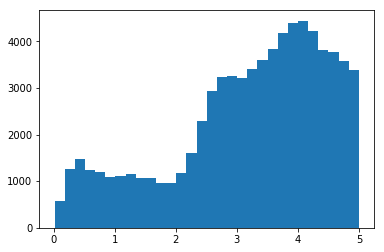

In [44]:
# EA: Find good parameter values for eps and minPts
# ==> Hyperparameter scaling using GridSearch too much?
M = createDistanceMatrix(dataset)
X = M[np.triu_indices(len(M[0]),1)]
plt.hist(X[X<5],bins=30)
plt.show()

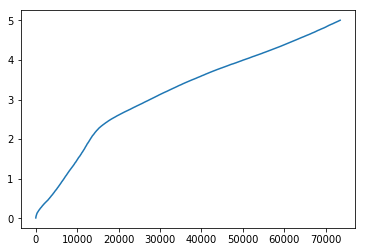

In [45]:
plt.plot(np.sort(X[X<5]))
plt.show()

In [93]:
# best eps = 2
# best minPts => 2-4
labs = DBSCAN(dataset, eps = 2, minPts = 2)

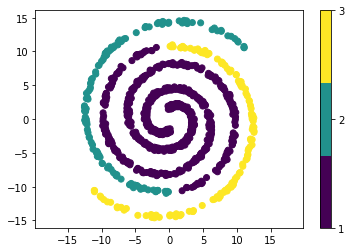

In [94]:
# EA: Does 'use matplotlib and numpy' mean that we are still allowed to use other libraries?
# Version only using plt and np
plt.scatter(dataset[:,0], dataset[:,1], c = labs, cmap=plt.get_cmap('viridis',len(set(labs))))
plt.colorbar(ticks=np.arange(0,len(set(labs)))+1)
plt.title('DBSCAN result for hyperspherical data set')
plt.axis('equal')
plt.show()

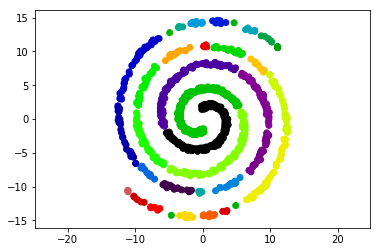

In [92]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from matplotlib.cm import nipy_spectral

def get_n_colors(n):
    return[nipy_spectral(float(i)/n) for i in range(n) ]

labs_col, _ = pd.factorize(labs)
colors = get_n_colors(max(labs_col)+1)
cc = np.array(colors)[labs_col]
plt.scatter(dataset[:,0], dataset[:,1], c = cc)
plt.axis('equal')
plt.show()

In [80]:
"""
# how to find the index of a specific point in the dataset:
point = dataset[12]

index = np.where((dataset==point).all(axis=1))
print(dataset[index][0])
"""

'\n# how to find the index of a specific point in the dataset:\npoint = dataset[12]\n\nindex = np.where((dataset==point).all(axis=1))\nprint(dataset[index][0])\n'

## Part C:  Print accuracies for different data_size values

In [152]:
def Adjusted_Rand_Index(labels):
    """
    Compute ARI for data labelling
    """
    n = len(labels)
    ari = np.zeros((n,n))
    for i in range(n):
        x = labels[i]
        for j in range(n):
            ari[i,j] = int(x==labels[j])
    return np.triu(ari,1)

def Adjusted_Rand_Score(X,Y):
    """
    X : ari of ground truth labels
    Y : ari of clutering result
    """
    ars = X==Y
    ars = np.count_nonzero(ars.astype(int))/float(X.size)
    return ars

In [157]:
acc = []
for data_size in range(100,5000,100):
    dataset = twospirals(data_size)
    labels = np.hstack((np.zeros(data_size),np.ones(data_size)))
    labs = DBSCAN(dataset, eps=2, minPts=3)
    x = Adjusted_Rand_Index(labels)
    y = Adjusted_Rand_Index(labs)
    acc.append(Adjusted_Rand_Score(x,y))

KeyboardInterrupt: 

In [158]:
len(acc)

13

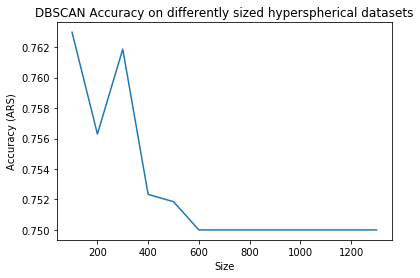

In [160]:
plt.figure()
plt.plot(range(100,5000,100)[:13], acc)
plt.title('DBSCAN Accuracy on differently sized hyperspherical datasets')
plt.xlabel('Size')
plt.ylabel('Accuracy (ARS)')
plt.show()

## Part D

### For what kind of data_size values does the algorithm fail and why?
EA:

In the accuracy plot above it looks like that for increasing data sizes, the algorithm converges to 75% accuracy. But then again, I stopped at around 12000 instances; also, another evaluation metric could give different accuracy results.


Assumption (for hyperspherical dataset of this assignment): 
- the bigger the data set, the denser the data distribution and the better the performance of a density-based approach


Observation: 
- Adjusted Rand Score decreases with larger data sets until it converges (why is that?)

### What would you say are disadvantages of DBSCAN?
- DBSCAN performs inferior on data sets with different densities across the feature space